## Dataset sources:
1. NRN Ontario GeoPackage: https://open.canada.ca/data/en/dataset/3d282116-e556-400c-9306-ca1a3cada77f/resource/d07a84dd-863c-4d60-9c08-0b33b6120427
2. Toronto neighbourhood spatial data: https://open.toronto.ca/dataset/neighbourhoods/
2. MSC Datamart weather station data: https://eccc-msc.github.io/open-data/msc-datamart/readme_en/
3. Traffic volume and speed data: https://open.toronto.ca/dataset/traffic-volumes-midblock-vehicle-speed-volume-and-classification-counts/
4. Cleaned Toronto traffic KSI data: https://www.kaggle.com/datasets/jrmistry/killed-or-seriously-injured-ksi-toronto-clean
5. Toronto collision dataset: https://open.toronto.ca/dataset/police-annual-statistical-report-traffic-collisions/

## Installing useful modules

In [1]:
!pip install geopandas fiona shapely rtree pyproj networkx osmnx folium torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.3/101.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import folium as fol
import json

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch_geometric as pyg


from shapely.geometry import Point

## Section 0: Preprocessing of csv data to create gpd

In [5]:
## Converting cleaned KSI dataset into a geodataframe
## note: this dataset only contains data up until 2017

# loading .csv into a pd
cksi_pd = pd.read_csv('/content/drive/MyDrive/2. UofT/2024-2025 (PEY)/Summer 2025/APS360 (2025)/APS360 2025 Project/3. Data and processing/APS360_KSI_CLEAN.csv')

# creating geometry from long and lat
geometry = gpd.points_from_xy(cksi_pd['LONGITUDE'], cksi_pd['LATITUDE'])

# converting pd to gpd and dropping long and lat columns
cksi_gpd = gpd.GeoDataFrame(cksi_pd, geometry = geometry, crs = 'EPSG:4617')
cksi_gpd.drop(columns = ['LATITUDE', 'LONGITUDE'], inplace = True)

## Section 1: Clipping datasets to downtown core

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# available layers: 'NRN_ON_18_0_TOLLPOINT' (default), 'NRN_ON_18_0_FERRYSEG', 'NRN_ON_18_0_JUNCTION', 'NRN_ON_18_0_ROADSEG', 'NRN_ON_18_0_BLKPASSAGE', 'NRN_ON_18_0_STRPLANAME', 'NRN_ON_18_0_ADDRANGE'
roads_gpd = gpd.read_file("/content/drive/MyDrive/2. UofT/2024-2025 (PEY)/Summer 2025/APS360 (2025)/APS360 2025 Project/3. Data and processing/NRN_RRN_ON_GPKG/NRN_ON_18_0_GPKG_en.gpkg", layer = 'NRN_ON_18_0_ROADSEG')

ksi_gpd = gpd.read_file('/content/drive/MyDrive/2. UofT/2024-2025 (PEY)/Summer 2025/APS360 (2025)/APS360 2025 Project/3. Data and processing/Motor Vehicle Collisions with KSI Data - 4326.gpkg')

collisions_gpd = gpd.read_file('/content/drive/MyDrive/2. UofT/2024-2025 (PEY)/Summer 2025/APS360 (2025)/APS360 2025 Project/3. Data and processing/Traffic Collisions - 4326.gpkg')

nbhds_gpd = gpd.read_file("/content/drive/MyDrive/2. UofT/2024-2025 (PEY)/Summer 2025/APS360 (2025)/APS360 2025 Project/3. Data and processing/Neighbourhoods - 4326.gpkg")

<Axes: >

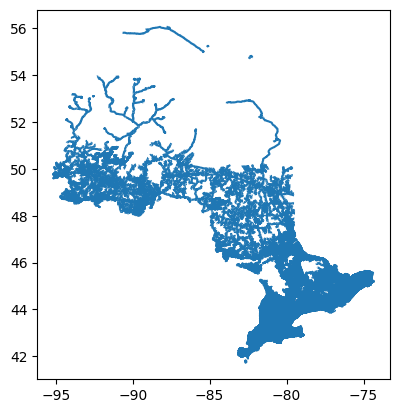

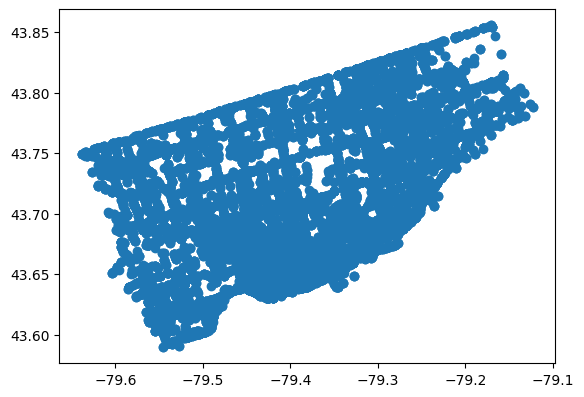

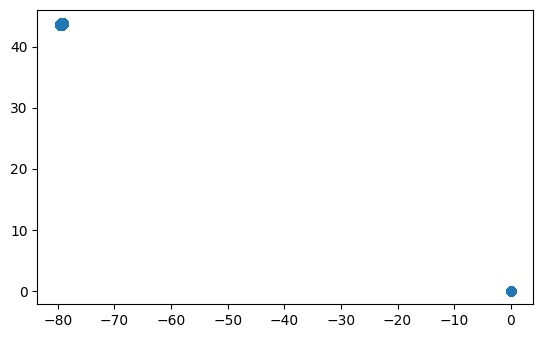

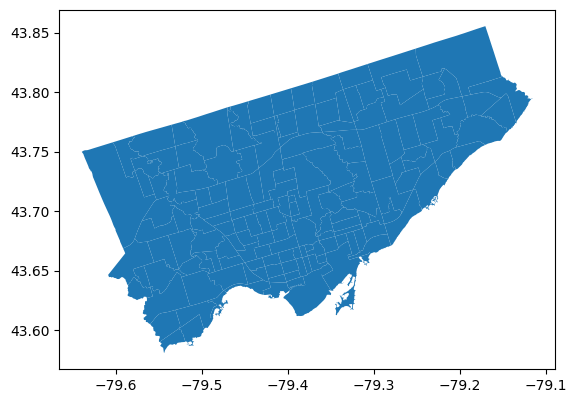

In [7]:
# plotting the entire road network layer
roads_gpd.plot()

# plotting the ksi spatial map
ksi_gpd.plot()

# plotting the collision spatial map
collisions_gpd.plot()

# plotting the neighbourhood spatial map
nbhds_gpd.plot()

In [8]:
## creating downtown core polygon

# filtering to downtown core neighhbourhoods
dtc_nbhds = ['Annex', 'University', 'Kensington-Chinatown', 'Wellington Place', 'Bay-Cloverhill', 'Yonge-Bay Corridor', 'Church-Wellesley', 'Downtown Yonge East', 'North St.James Town', \
             'Cabbagetown-South St.James Town', 'Moss Park', 'Regent Park', 'Harbourfront-CityPlace']

nbhds_gpd_f = nbhds_gpd[nbhds_gpd['AREA_NAME'].isin(dtc_nbhds)]


# dissolving to create combined polygon
nbhds_gpd_fd = nbhds_gpd_f.dissolve()


# reprojecting to match NRN road network
nbhds_gpd_fdr = nbhds_gpd_fd.to_crs(epsg=4617)
ksi_gpd = ksi_gpd.to_crs(epsg=4617)
collisions_gpd = collisions_gpd.to_crs(epsg=4617)



## using polygon to clip the NRN road network
roads_gpd_clipped = gpd.clip(roads_gpd, nbhds_gpd_fdr['geometry'], keep_geom_type=True)
cksi_gpd_clipped = gpd.clip(cksi_gpd, nbhds_gpd_fdr['geometry'], keep_geom_type=True)
ksi_gpd_clipped = gpd.clip(ksi_gpd, nbhds_gpd_fdr['geometry'], keep_geom_type=True)
collisions_gpd_clipped = gpd.clip(collisions_gpd, nbhds_gpd_fdr['geometry'], keep_geom_type=True)

<Axes: >

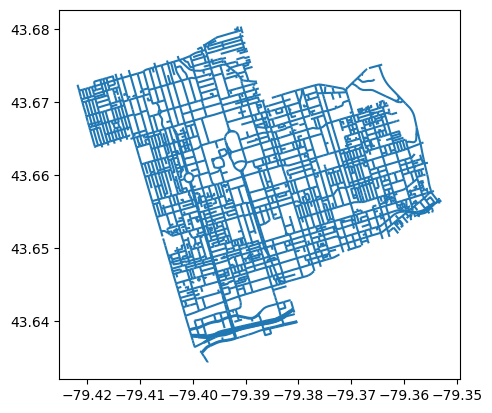

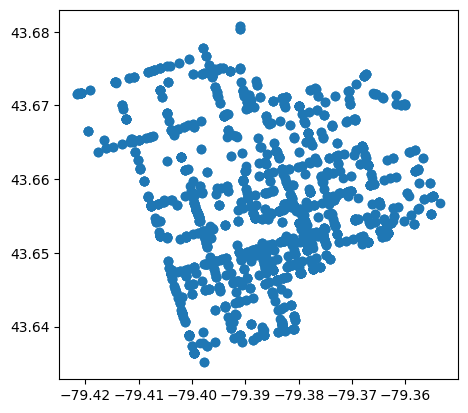

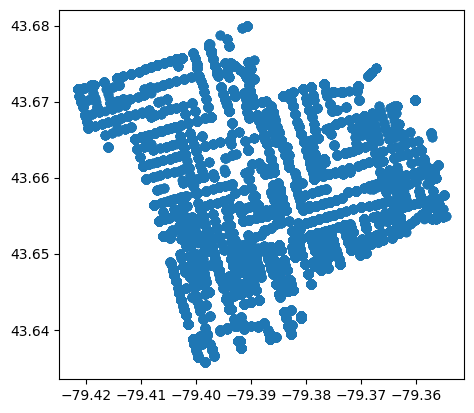

In [9]:
# sanity check
roads_gpd_clipped.plot()
ksi_gpd_clipped.plot()
collisions_gpd_clipped.plot()

## Section 2: Extracting nodes and edges from downtown core network

In [10]:
## extracting endpoints geodataframe (these are the nodes)

# retrieving endpoints for each geometry
endpts = roads_gpd_clipped['geometry'].boundary

# turning multipoints into single points, removing duplicates, and resetting index
endpts = endpts.explode().drop_duplicates()


<Axes: >

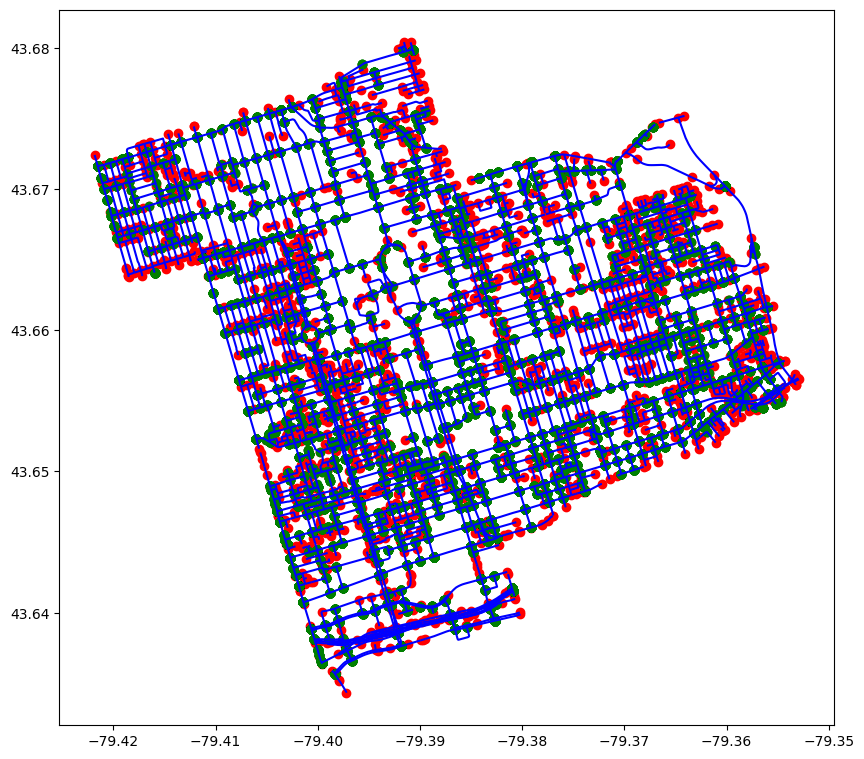

In [11]:
## visualizing everything at once (across entire timescale)

fig, ax = plt.subplots(figsize=(10,10))
roads_gpd_clipped.plot(ax = ax, color = 'blue')
endpts.plot(ax = ax, color = 'red')
collisions_gpd_clipped.plot(ax = ax, color = 'green')

In [12]:
## extracting edges and edge attributes

# creating endpoints dictionary to assign ordering to the nodes
endpts_dict = {(pt.x, pt.y): ind for ind, pt in enumerate(endpts)}


# creating edge list using above endpoint ordering by corresponding coords to endpts
edges = []
edge_atts = []

for i, row in roads_gpd_clipped.explode().iterrows():

    # creating undirected edge list
    start = row['geometry'].coords[0]
    end = row['geometry'].coords[-1]

    u_pos = endpts_dict[start]
    v_pos = endpts_dict[end]

    edges.append((u_pos, v_pos))
    edges.append((v_pos, u_pos))


    # creating edge attribute matrix
    tortuosity = row['geometry'].length / Point(start).distance(Point(end))

    edge_atts.append([row['PAVSTATUS'], row['ROADCLASS'], row['NBRLANES'], row['TRAFFICDIR'], row['geometry'].length, tortuosity])

In [13]:
## for preliminary pruposes, creating edge weights from only tortuosity

# Create a list of tortuosity values for each geometry
tortuosity_list = [row[-1] for row in edge_atts]

# Duplicate the tortuosity values to match the number of directed edges
edge_wts = tortuosity_list + tortuosity_list

## Section 3: Snapping collisions to nearest nodes and collision making timeseries

In [14]:
# modifying coll gpd
collisions_gpd_clipped.drop_duplicates(subset = ['OCC_MONTH', 'OCC_DOW', 'OCC_YEAR', 'OCC_HOUR', 'geometry'], keep = 'first')


## snapping collisions to nearest nodes

# Convert the endpts GeoSeries to a GeoDataFrame
endpts_gdf = gpd.GeoDataFrame(geometry = endpts)
endpts_gdf["NODE_ID"] = [i for i in range(len(endpts))]

snap = gpd.sjoin_nearest(collisions_gpd_clipped, endpts_gdf, how = 'left', distance_col = 'dist')


# grouping modified coll into hours and making timeseries

coll_grouped = snap.groupby(['OCC_MONTH', 'OCC_DOW', 'OCC_YEAR', 'OCC_HOUR'])

coll_timeseries = []

for i in list(coll_grouped.groups):                        # gets key from list of keys
  coll_timeseries.append(coll_grouped.get_group(i))        # uses that key to access value (which are the gpd indices) and uses that as arg for .get_group()

/usr/local/lib/python3.11/dist-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


## Section 3 EXTRA: Grouping KSI gpd by dates and hours to make a KSI timeseries

In [151]:
## first modifying and grouping cski gpd and then making timeseries

cksi_grouped = cksi_gpd_clipped.groupby(['YEAR', 'MONTH', 'DAY', 'HOUR'])

cksi_timeseries = []

for i in list(cksi_grouped.groups):                        # gets key from list of keys
  cksi_timeseries.append(cksi_grouped.get_group(i))        # uses that key to access value (which are the gpd indices) and uses that as arg for .get_group()

In [152]:
## next, modifying ksi gpd, grouping, and making timeseries

# modifying ksi gpd to get hours and minutes
ksi_gpd_clipped['HOUR'] = ksi_gpd_clipped['TIME'].str.slice(0, -2)
ksi_gpd_clipped['MINUTES'] = ksi_gpd_clipped['TIME'].str.slice(-2)

ksi_gpd_clipped.insert(ksi_gpd_clipped.columns.get_loc('TIME'), 'HOUR', ksi_gpd_clipped.pop('HOUR'))
ksi_gpd_clipped.insert(ksi_gpd_clipped.columns.get_loc('TIME'), 'MINUTES', ksi_gpd_clipped.pop('MINUTES'))

ksi_gpd_cd = ksi_gpd_clipped.drop(columns = ['TIME'])
ksi_gpd_cd.drop_duplicates(subset = ['DATE', 'HOUR', 'geometry'], keep = 'first')


# grouping modified ksi into date and hours
ksi_grouped = ksi_gpd_cd.groupby(['DATE', 'HOUR'])


# making timeseries
ksi_timeseries = []

for i in list(ksi_grouped.groups):                                  # gets key from list of keys
  ksi_timeseries.append(ksi_grouped.get_group(i).iloc[[0]])         # uses that key to access value (which are the gpd indices) and uses that as arg for .get_group()

## Section 4: Building node feature matrices, edge direction matrices, and ground thruth labels

In [15]:
## creating a timeseries of node feature matrices

node_matrix_timeseries = []

for timepoint in range(len(coll_timeseries)):

  # preallocating np array with one column (for collision boolean)
  node_matrix = np.zeros((len(endpts), 9), dtype = np.float64)

  timepoint_feats = coll_timeseries[timepoint][['INJURY_COLLISIONS', 'FTR_COLLISIONS', 'PD_COLLISIONS', 'AUTOMOBILE', 'MOTORCYCLE', 'PASSENGER', 'BICYCLE', 'PEDESTRIAN', 'NODE_ID']]

  # node_ids which have a collision
  pos_list = list(coll_timeseries[timepoint]["NODE_ID"])


  for i in range(len(timepoint_feats)):
    if timepoint_feats.iloc[i][-1] in pos_list:
      node_matrix[timepoint_feats.iloc[i][-1], :] = [1] + [1 if j == "YES" else 0 for j in list(timepoint_feats.iloc[i])[:-1]]

  node_matrix_timeseries.append(node_matrix)

node_matrix_timeseries = np.array(node_matrix_timeseries)

Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-15-4070550125.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if timepoint_feats.iloc[i][-1] in pos_list:
/tmp/ipython-input-15-4070550125.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  node_matrix[timepoint_feats.iloc[i][-1], :] = [1] + [1 if j == "YES" else 0 for j in list(timepoint_feats.iloc[i])[:-1]]
/tmp/ipython-input-15-4070550125.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a val

In [16]:
## creating timeseries of ground truth labels
label_timeseries = []

for i in range(len(node_matrix_timeseries)):

  label_vector = np.zeros(len(endpts), dtype = np.float64)

  for j in range(len(node_matrix_timeseries[i])):
    if node_matrix_timeseries[i][j][0] == 1:
      label_vector[j] = 1

  label_timeseries.append(label_vector)

label_timeseries = np.array(label_timeseries)

In [17]:
# santiy check:
node_matrix_timeseries.shape
label_timeseries.shape

(18550, 2634)

In [18]:
## creating torch tensors of the correct shapes to feed into a GCN layer


# creating matrix of shape [2, E] for edges
sources, targets = zip(*edges)
edge_index_tensor = torch.tensor([sources, targets], dtype=torch.long)

# turning edge weights into torch tensor
edge_weight_tensor = torch.tensor(edge_wts, dtype = torch.float)

# turning node feature timeseries into torch tensor
node_matrix_timeseries_tensor = torch.tensor(node_matrix_timeseries, dtype = torch.float)

# turning labels into torch tensor
label_timeseries_tensor = torch.tensor(label_timeseries, dtype = torch.float)


## using the crashes at t+1 as the label for node features at t
labels = label_timeseries_tensor = label_timeseries_tensor[1:]
node_features = node_matrix_timeseries_tensor = node_matrix_timeseries_tensor[:-1]

In [19]:
# loading all of these into a PyG Data object
data_list = []

for i in range(len(node_features)):
  data_list.append(pyg.data.Data(x = node_features[i], edge_index = edge_index_tensor, edge_attr = edge_weight_tensor, y = labels[i]))

## Section 5: Building baseline and prelim models and implementating training functions

In [34]:
## creating baseline GCN model

from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(GCN, self).__init__()
    self.name = 'baseline'

    torch.manual_seed(10000)

    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)


  def forward(self, x, edge_index, edge_weight):
    x = self.conv1(x, edge_index, edge_weight)
    x = F.relu(x)
    x = self.conv2(x, edge_index, edge_weight)

    return x

In [35]:
## creating preliminary ANN-GCN hybrid

class ANN_GCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_linear, out_linear, hidden_channels, out_channels):
    super(ANN_GCN, self).__init__()
    self.name = 'prelim'

    torch.manual_seed(10000)

    self.linear1 = nn.Linear(in_channels, hidden_linear)
    self.linear2 = nn.Linear(hidden_linear, out_linear)
    self.conv1 = GCNConv(out_linear, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)


  def forward(self, x, edge_index, edge_weight):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.conv1(x, edge_index, edge_weight)
    x = F.relu(x)
    x = self.conv2(x, edge_index, edge_weight)

    return x

In [36]:
## creating data_loader objects
data_loader = pyg.loader.DataLoader(data_list, batch_size = 2, shuffle = True)

In [42]:
## implementing training functions

def train_net(net, data_list, batch_size, learning_rate, epochs):

    # first, loading all data based on dataset and target_classes:
    torch.manual_seed(1000)

    split = int(0.8 * len(data_list))

    train_data = data_list[:split]
    val_data = data_list[split:]

    train_loader = pyg.loader.DataLoader(train_data, batch_size = batch_size, shuffle = True)
    val_loader = pyg.loader.DataLoader(val_data, batch_size = batch_size, shuffle = False)


    # Moving net to GPU if available
    if torch.cuda.is_available():
      net = net.cuda()

    # Using BCEWithLogitsLoss for binary classification
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr = learning_rate)

    # training the network and recording train and val accuracies
    train_accuracy = np.zeros(epochs)
    val_accuracy = np.zeros(epochs)

    for epoch in range(epochs):

      num_correct = 0
      total = 0

      net.train() # Set the model to training mode
      for i, batch in enumerate(train_loader):

        node_feats = batch.x
        edge_atts = batch.edge_attr
        edge_index = batch.edge_index
        labels = batch.y.unsqueeze(1) # Add a dimension to match output shape


        # Moving tensors to the GPU if available
        if torch.cuda.is_available():
          node_feats = node_feats.cuda()
          edge_atts = edge_atts.cuda()
          edge_index = edge_index.cuda()
          labels = labels.cuda()

        # doing forward and backward pass
        optimizer.zero_grad()
        outputs = net(node_feats, edge_index, edge_atts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # computing the training accuracy
        prediction = (torch.sigmoid(outputs) > 0.5).float()
        comparison = torch.eq(prediction, labels)
        num_correct += int(torch.sum(comparison))
        total += labels.size(0) # Use the actual number of nodes in the batch


      train_accuracy[epoch] = num_correct / total
      val_accuracy[epoch] = accuracy(net, val_loader)

      # Saving model checkpoint
      model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
      torch.save(net.state_dict(), model_path)

      # Printing results:
      print("Epoch: {}, training accuracy: {}, validation accuracy: {}".format(epoch + 1, train_accuracy[epoch], \
            val_accuracy[epoch]))

    epochs = np.arange(1, epochs + 1)

    return train_accuracy, val_accuracy, epochs


def accuracy(net, loader):
    """
    This function evaluates a given model iteration on a dataset and returns the accuracy
    for that dataset.
    (nn.Module), (DataLoader) --> (int)
    """
    net.eval() # Set the model to evaluation mode
    num_correct = 0
    total = 0

    # evaluating the model on the given dataset and computing the accuracies
    with torch.no_grad(): # Disable gradient calculation for evaluation
        for i, batch in enumerate(loader):

          node_feats = batch.x
          edge_atts = batch.edge_attr
          edge_index = batch.edge_index
          labels = batch.y.unsqueeze(1) # Add a dimension to match output shape

          # Moving tensors to the GPU if available
          if torch.cuda.is_available():
            node_feats = node_feats.cuda()
            edge_atts = edge_atts.cuda()
            edge_index = edge_index.cuda()
            labels = labels.cuda()

          net_output = net(node_feats, edge_index, edge_atts)

          # computing the training accuracy
          prediction = (torch.sigmoid(net_output) > 0.5).float()
          comparison = torch.eq(prediction, labels)

          num_correct += int(torch.sum(comparison))
          total += labels.size(0) # Use the actual number of nodes in the batch


    return num_correct / total


def get_model_name(name, batch_size, learning_rate, epoch):

    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path


def plot_training_curve(training_accuracy, val_accuracy, epochs):
    """ Plots the training curve for a model run, given training and
    validation accuracy.
    """
    import matplotlib.pyplot as plt

    plt.plot(epochs, training_accuracy, label = "Training accuracy")
    plt.plot(epochs, val_accuracy, label = "Validation accuracy")
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [38]:
baseline = GCN(9, 16, 1)
prelim = ANN_GCN(9, 16, 5, 16, 1)

Epoch: 1, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 2, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 3, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 4, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 5, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 6, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 7, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 8, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 9, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 10, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334


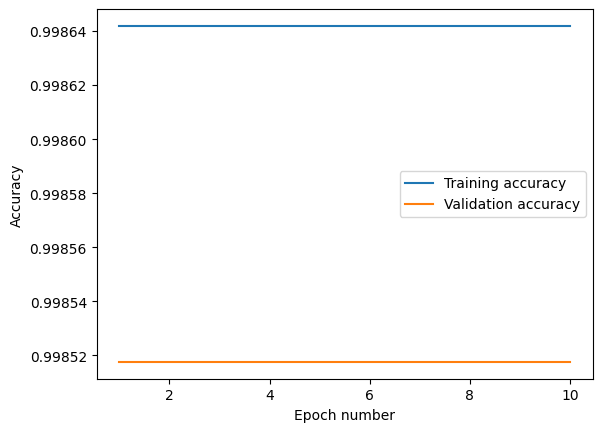

In [40]:
train_acc, val_acc, epochs = train_net(baseline, data_list, 20, 0.0001, 10)
plot_training_curve(train_acc, val_acc, epochs)

Epoch: 1, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 2, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 3, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 4, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 5, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 6, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 7, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 8, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 9, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334
Epoch: 10, training accuracy: 0.9986419152510292, validation accuracy: 0.9985175202156334


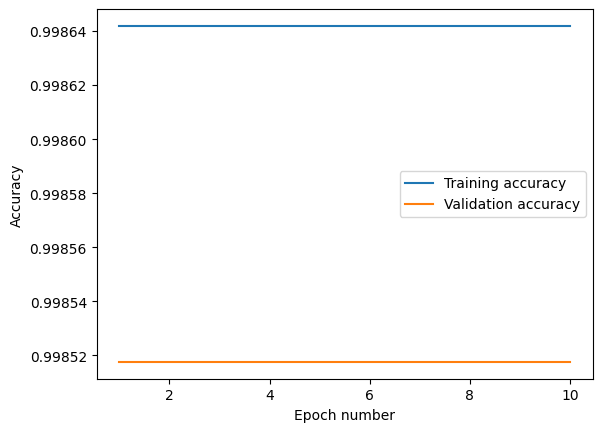

In [41]:
train_acc, val_acc, epochs = train_net(prelim, data_list, 20, 0.0001, 10)
plot_training_curve(train_acc, val_acc, epochs)